In [48]:
import importlib
import utils as ut
from transformers import AutoModelForCausalLM, AutoTokenizer
from nanoGPT import model
import tiktoken

hf_gpt_model = AutoModelForCausalLM.from_pretrained("gpt2")
hf_gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")

nanoGPT_model = model.GPT.from_pretrained("gpt2", dict(dropout=0))
nanoGPT_model.eval()
tiktoken_tokenizer = tiktoken.get_encoding("gpt2")


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0
number of parameters: 123.65M


<module 'models' from '/Users/jdvin/Code/personal/whistle-stop/models.py'>

=== Beginning Model Testing ===
=> Testing model HF Base (1/5).
==> Running speed test...


  0%|          | 0/20 [00:00<?, ?it/s]

==> Complete!
==> Running perplexity test...
==> Complete!
=> Testing model Onnx Base (2/5).
==> Running speed test...


  0%|          | 0/20 [00:00<?, ?it/s]

==> Complete!
==> Running perplexity test...
==> Complete!
=> Testing model Onnx Quant (3/5).
==> Running speed test...


  0%|          | 0/20 [00:00<?, ?it/s]

==> Complete!
==> Running perplexity test...
==> Complete!
=> Testing model Onnx Opt (4/5).
==> Running speed test...


  0%|          | 0/20 [00:00<?, ?it/s]

==> Complete!
==> Running perplexity test...
==> Complete!
=> Testing model Onnx Opt Quant (5/5).
==> Running speed test...


  0%|          | 0/20 [00:00<?, ?it/s]

==> Complete!
==> Running perplexity test...
==> Complete!
== Model Testing Complete! - Plotting results... ==


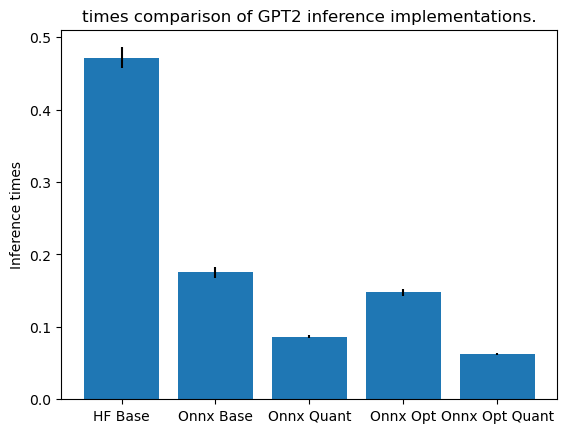

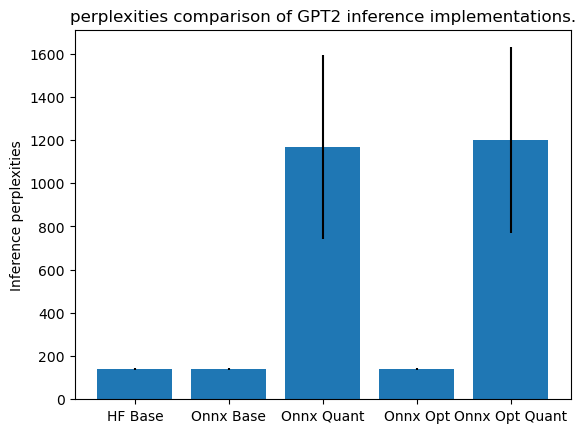

In [437]:
importlib.reload(ut)

base_hf_tester = ut.ModelTester(
    model_name="HF Base",
    model_func=ut.hf_lm_pipe(tokenizer=hf_gpt_tokenizer, model=hf_gpt_model),
)
compiled_hf_tester = ut.ModelTester(
    model_name="compiled_hf-hf",
    model_func=ut.compiled_hf_lm_pipe(
        tokenizer=hf_gpt_tokenizer, model=hf_gpt_model
    ),
)

nanoGPT_tester = ut.ModelTester(
    model_name="nanoGPT",
    model_func=ut.nanoGPT_pipe(tiktoken_tokenizer, nanoGPT_model),
)


onnx_base_tester = ut.ModelTester(
    model_name="Onnx Base",
    model_func=ut.onnx_custom_pipe(
        hf_gpt_tokenizer,
        model_path="models/gpt2_base.onnx",
        n_attention_heads=hf_gpt_model.config.n_head,
        hidden_size=hf_gpt_model.config.n_embd,
        n_layers=hf_gpt_model.config.n_layer,
    ),
)
onnx_quant_tester = ut.ModelTester(
    model_name="Onnx Quant",
    model_func=ut.onnx_custom_pipe(
        hf_gpt_tokenizer,
        model_path="models/gpt2_quant.onnx",
        n_attention_heads=hf_gpt_model.config.n_head,
        hidden_size=hf_gpt_model.config.n_embd,
        n_layers=hf_gpt_model.config.n_layer,
    ),
)

onnx_opt_tester = ut.ModelTester(
    model_name="Onnx Opt",
    model_func=ut.onnx_custom_pipe(
        hf_gpt_tokenizer,
        model_path="models/gpt2_opt.onnx",
        n_attention_heads=hf_gpt_model.config.n_head,
        hidden_size=hf_gpt_model.config.n_embd,
        n_layers=hf_gpt_model.config.n_layer,
    ),
)
onnx_opt_quant_tester = ut.ModelTester(
    model_name="Onnx Opt Quant",
    model_func=ut.onnx_custom_pipe(
        hf_gpt_tokenizer,
        model_path="models/gpt2_opt_quant.onnx",
        n_attention_heads=hf_gpt_model.config.n_head,
        hidden_size=hf_gpt_model.config.n_embd,
        n_layers=hf_gpt_model.config.n_layer,
    ),
)

testers = [
    # nanoGPT_tester,
    base_hf_tester,
    # compiled_hf_tester,
    # compiled_nanoGPT_tester,
    onnx_base_tester,
    onnx_quant_tester,
    onnx_opt_tester,
    onnx_opt_quant_tester,
]

tests_per_model = 20
prompt_length = 10
test_sequences = [
    "The Wright brothers invented and flew the first airplane in 1903, recognized as 'the first sustained and controlled heavier-than-air powered flight'. They built on the works of George Cayley dating from 1799, when he set forth the concept of the modern airplane (and later built and flew models and successful passenger-carrying gliders). Between 1867 and 1896, the German pioneer of human aviation Otto Lilienthal also studied heavier-than-air flight. Following its limited use in World War I, aircraft technology continued to develop. Airplanes had a presence in all the major battles of World War II. The first jet aircraft was the German Heinkel He 178 in 1939. The first jet airliner, the de Havilland Comet, was introduced in 1952. The Boeing 707, the first widely successful commercial jet, was in commercial service for more than 50 years, from 1958 to at least 2013.",
    "Telecommunications is about transferring information from one location to another. This includes many forms of information: telephone conversations, television signals, computer files, and other types of data. To transfer the information, you need a channel between the two locations. This may be a wire pair, radio signal, optical fiber, etc. Telecommunications companies receive payment for transferring their customer's information, while they must pay to establish and maintain the channel. The financial bottom line is simple: the more information they can pass through a single channel, the more money they make. DSP has revolutionized the telecommunications industry in many areas: signaling tone generation and detection, frequency band shifting, filtering to remove power line hum, etc. Three specific examples from the telephone network will be discussed here: multiplexing, compression, and echo control.",
]
max_generation_length = 20


# random.shuffle(testers)
print("=== Beginning Model Testing ===")
for i, model_tester in enumerate(testers):
    print(f"=> Testing model {model_tester.model_name} ({i+1}/{len(testers)}).")
    print(f"==> Running speed test...")
    # Conduct multiple tests to account for variance resulting from machine-level sources.
    model_tester.run_speed_test(
        n_tests=tests_per_model,
        prompt_length=prompt_length,
        max_generation_length=max_generation_length,
        tokenizer=hf_gpt_tokenizer,
    )
    print(f"==> Complete!")
    print(f"==> Running perplexity test...")
    ut.analyse_lm_performance(test_sequences, hf_gpt_tokenizer, model_tester)
    print(f"==> Complete!")

print("== Model Testing Complete! - Plotting results... ==")
ut.plot_test_results(model_testers=testers, result_type="times")
ut.plot_test_results(model_testers=testers, result_type="perplexities")


testers[0].outputs


In [413]:
"""straight from: https://onnxruntime.ai/docs/performance/quantization.html"""

import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

model_fp32 = "models/gpt2_opt.onnx"
model_quant = "models/gpt2_opt_quant.onnx"
quantized_model = quantize_dynamic(model_fp32, model_quant)


In [412]:
"""Trying pre-quantisation optimisation as per: https://github.com/microsoft/onnxruntime-inference-examples/blob/main/quantization/notebooks/bert/Bert-GLUE_OnnxRuntime_quantization.ipynb"""

import onnxruntime
from onnxruntime_tools import optimizer

opt_model = optimizer.optimize_model(
    "models/gpt2_base.onnx",
    "gpt2",
    num_heads=hf_gpt_model.config.n_head,
    hidden_size=hf_gpt_model.config.n_embd,
)
# optimization_options=opt_options)
opt_model.save_model_to_file("models/gpt2_opt.onnx")
